Importing the Libraries

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing and Preprocessing the Training Data

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [3]:
training_set = dataset_train.iloc[:, 1:2].values #using 1:2 makes a 2d array with just one column, if just 1 was used it would have created single array
print(training_set)
training_set.shape

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]


(1258, 1)

Scaling The Data

In [32]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1)) # we want the scaled values to be between 0 and 1
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


Creating a data structure with 60 timesteps(prices) and 1 output(next day price)

In [5]:
#x_train will contain the prev 60 days prices and y_train will comtain the next day price
x_train = []
y_train = []

for i in range(60, len(training_set)):
  # 0 is important other it will add a 2d array to x_train and 1d array to y_train making them 3d and 2d arrays respectively
  x_train.append(training_set_scaled[i-60:i, 0]) #this will add the sliced array as one array to x_train
  y_train.append(training_set_scaled[i, 0]) # this will add just one value at the end of y_train

x_train = np.array(x_train)
y_train = np.array(y_train)
#recurrent layers in keras take 3d tensors so we need to reshape x_rain and y_train
# we could have either removed 0 from the append
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1) # actually here the 3rd dimension can be used for taking more correlated stocks
print(x_train.shape, y_train.shape) #x_train and y_train are lists and needs to be converted to array

(1198, 60, 1) (1198,)


Building and Training the LSTM

In [6]:
regressor = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)), #input shape = (60, 1) added only for the first layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50), #here we wont return any sequences, default=False
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1) #output layer
])
regressor.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
regressor.fit(x=x_train, y=y_train, batch_size=32, epochs=100)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.1095
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0062
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0051
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0048
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0052
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0051
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0042
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0044
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0056
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0045
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0049
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0039
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0041
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0037
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5

In [18]:
regressor.save('StockPricePredictionLSTM.keras')

Making predictions and Visualising the Results

In [33]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
actual_outputs = dataset_test.iloc[:, 1:2].values

dataset_combined = pd.concat((dataset_train, dataset_test), axis=0)
dataset_combined.info()
start = len(dataset_combined) - len(dataset_test)
dataset_combined = dataset_combined.iloc[start-60:, 1:2].values
dataset_combined = sc.transform(dataset_combined)
print(dataset_combined.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 69.9+ KB
(80, 1)


In [34]:
test_inputs = []
for i in range(60, len(dataset_combined)):
  test_inputs.append(dataset_combined[i-60:i, 0])

test_inputs = np.array(test_inputs)
test_inputs = test_inputs.reshape(test_inputs.shape[0], test_inputs.shape[1], 1)
print(test_inputs.shape)
print(actual_outputs.shape)

(20, 60, 1)
(20, 1)


In [35]:
predicted_outputs = regressor.predict(test_inputs)
predicted_outputs = sc.inverse_transform(predicted_outputs)
print(predicted_outputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[788.6546 ]
 [785.5272 ]
 [785.3816 ]
 [786.61865]
 [789.70935]
 [795.2034 ]
 [800.1903 ]
 [801.8841 ]
 [801.61255]
 [801.0122 ]
 [800.8352 ]
 [800.9676 ]
 [801.28577]
 [802.262  ]
 [803.5881 ]
 [808.3553 ]
 [815.4081 ]
 [822.74146]
 [826.4106 ]
 [821.7701 ]]


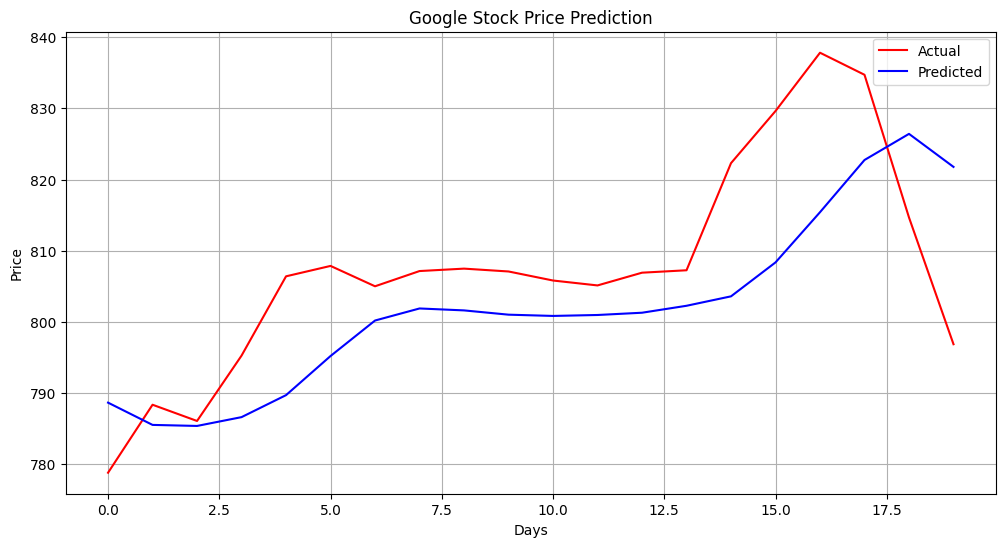

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_outputs, color='red', label='Actual')
plt.plot(predicted_outputs, color='blue', label='Predicted')
plt.title('Google Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('Prediction.png')
plt.show()